# Tutorial: AI Return Nowcaster

## Introduction

This document explains how to use the AI Return Nowcaster **Short-term Return Nowcast** endpoint of the **Private Equity Model API** provided by [prettymodels.ai](https://prettymodels.ai). 
Our NAV discount endpoint is based on the paper of [Nadauld, Sensoy, Vorkink, Weisbach (2019)](https://doi.org/10.1016/j.jfineco.2018.11.007).


## Setup Python and API keys

In [1]:
# Load packages
import os
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# Define the API root URL
from api_root import base_product_url

## Available endpoints in the AI Return Nowcaster module

In [3]:
# AI RETURN NOWCASTER MODEL
model = "air_nowcaster"

endpoints = [
    "short_term_return_nowcast",
    "sdf_price_range",
    "nav_discount",
]

## Check available fund segments and macro environments

In [4]:
# Check available fund_segments and macro_environments (directly from the API)

fund_segments = requests.get(os.path.join(base_product_url, "common/fund_segments"))
print("fund_segments", fund_segments.json())
macro_environments = requests.get(
    os.path.join(base_product_url, "common/macro_environments")
)
print("macro_environments", macro_environments.json())

fund_segments ['BO', 'VC', 'PE', 'RE', 'PD', 'INF', 'NATRES', 'FOF']
macro_environments ['average', 'medium', 'super', 'good', 'bad', 'evil']


## Define the API request body

Specify your input parameters in the request body:

-   **fund\_segment**: choose from \[BO, VC, PE, RE, PD, INF, NATRES, FOF\]
-   **nav**: current fund Net Asset Value (NAV)
-   **age**: current fund age (in years)

**Please enter your own parameter assumptions!**


In [5]:
# Define the request bodies (each endpoint has a different request body)

request_body_short_term_return_nowcast = {
    "fund_segment": fund_segments.json()[0],
    "number_funds": 1, # to reflect diversification effects for holding multiple funds
}

request_body_sdf_price_range = {
    "list_input": [
        {"cash_flow_amount": 100, "exit_time": 1},
        {"cash_flow_amount": 150, "exit_time": 2},
    ],
    "fund_segment": fund_segments.json()[0],
    "macro_environment": macro_environments.json()[0],
    "rf_rate": 0,
}

request_body_nav_discount = {
    "fund_segment": fund_segments.json()[0],
    "nav": 100,
    "age": 10,
}

## Run the API requests

POST request successful: short_term_return_nowcast
POST request successful: sdf_price_range


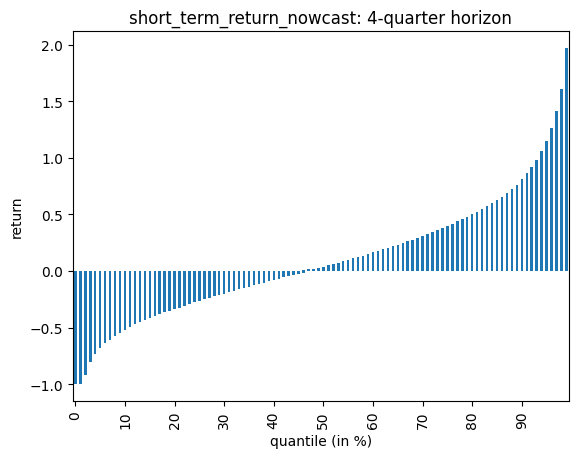

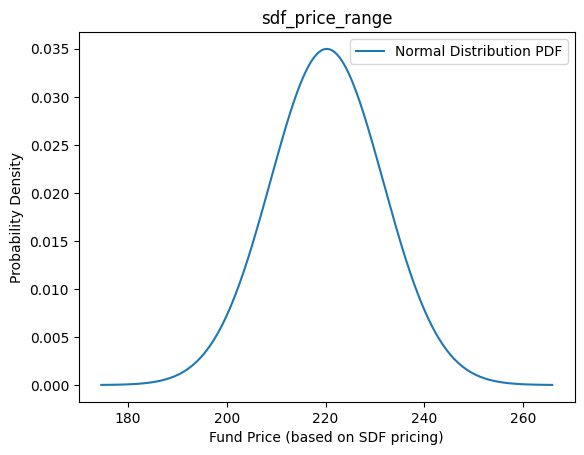

POST request successful: nav_discount


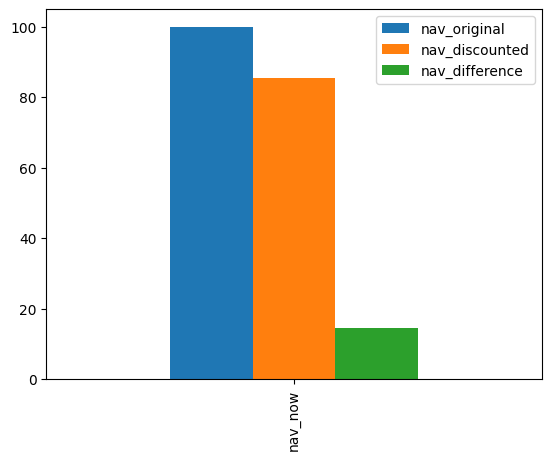

In [6]:

for endpoint in endpoints:
    # Build API URL
    url = os.path.join(base_product_url, model, endpoint)

    # Send the POST request
    if endpoint == "short_term_return_nowcast":
        request_body = request_body_short_term_return_nowcast
    elif endpoint == "sdf_price_range":
        request_body = request_body_sdf_price_range
    elif endpoint == "nav_discount":
        request_body = request_body_nav_discount
    else:
        raise ValueError(f"endpoint {endpoint} not defined.")

    # Set header for authentication
    headers = {"API-KEY": "not needed"}

    # Send the POST request
    response = requests.post(url, json=request_body)

    # Check the response status code
    if response.status_code == 200:
        # Request was successful
        print(f"POST request successful: {endpoint}")
        # print("Response JSON:", response.json())
    else:
        # Request failed
        print("POST request failed with status code:", response.status_code)

    # Convert dict to pd.DataFrame
    if endpoint == "sdf_price_range":
        df = pd.DataFrame(response.json(), index=["price_now"])
    elif endpoint == "nav_discount":
        df = pd.DataFrame(response.json(), index=["nav_now"])
    else:
        df = pd.DataFrame(response.json())

    # Save pd.DataFrame to .csv file
    df.to_csv(f"ai_return_nowcaster---{endpoint}.csv")
    
    if endpoint == "short_term_return_nowcast":
        df = df.drop('mean')
        df.index = df.index.str.split('quantile_').str.get(1)
        df.index = pd.to_numeric(df.index)
        for i in range(1,5):
            plot = df[f"quarter_{i}"].plot(title=f"{endpoint}: {i}-quarter horizon", xticks=np.arange(0, 100, 10),
                                           xlabel="quantile (in %)", ylabel="return", kind="bar")
    elif endpoint == "sdf_price_range":
        # Define the parameters of the normal distribution
        mean = df.loc["price_now", "price_mean"]
        std_dev = df.loc["price_now", "price_stdv"]
        
        # Generate x values
        x = np.linspace(mean - 4*std_dev, mean + 4*std_dev, 1000)
        
        # Calculate the PDF values for each x
        pdf_values = norm.pdf(x, mean, std_dev)

        # Create a new figure
        plt.figure()

        # Plot the PDF
        plt.plot(x, pdf_values, label='Normal Distribution PDF')
        
        # Add labels and a legend
        plt.xlabel('Fund Price (based on SDF pricing)')
        plt.ylabel('Probability Density')
        plt.title(endpoint)
        plt.legend()
        
        # Show the plot
        plt.show()
    elif endpoint == "nav_discount":
        df.plot.bar()
        